### 13장 텐서플로를 사용하여 신경망 훈련
- 3) 신경망 모델 만들기 
- 4) 활성화 함수 
--- 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

---
#### 1. iris 데이터 분류기 만들기 
---

In [2]:
## iris 데이터 로딩
import tensorflow as tf 
import tensorflow_datasets as tfds

iris, iris_info = tfds.load('iris', with_info = True)
iris_info

tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='C:\\Users\\Seoyeon\\tensorflow_datasets\\iris\\2.0.0',
    file_format=tfrecord,
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=float32),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    splits={
        't

In [3]:
## iris dataset은 한 덩어리 --> train/test set 구분 필요
## reshuffle_each_iteration = False : train/test 데이터가 섞이는 것 방지 
tf.random.set_seed(1)
ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration = False)
ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

## dict --> tupul 변환 
ds_train_orig = ds_train_orig.map(lambda x:(x['features'], x['label']))
ds_test = ds_test.map(lambda x:(x['features'], x['label']))

In [4]:
## 신경망 구성 : input 4 --> 16뉴런 --> 출력 3 
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation = 'sigmoid', name = 'fc1', input_shape = (4,)), 
    tf.keras.layers.Dense(3, activation = 'softmax', name = 'fc2')    
    ])

iris_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [5]:
## 신경망 컴파일 
iris_model.compile(optimizer = 'adam', 
                   loss = 'sparse_categorical_crossentropy', 
                   metrics = ['accuracy'])

In [6]:
## model fit ~ epochs = 100, batch_size = 2
## steps_per_epoch = 훈련 샘플 수 / 배치 사이즈, 한 세대의 종료를 선언하고 다음 세대를 시작하기까지 단계(샘플 배치)의 총 개수
## verbose : 함수 수행시 발생하는 상세한 정보들을 표준 출력으로 자세히 내보낼 것인가? 0 은 출력하지 않고, 1은 자세히, 2는 함축적인 정보만 출력
training_size = 100 
batch_size = 2
steps_per_epoch = np.ceil(training_size/batch_size)

ds_train = ds_train_orig.shuffle(buffer_size = training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size = batch_size)
ds_train = ds_train.prefetch(buffer_size = 1000)

history = iris_model.fit(ds_train, epochs = 100, 
                         steps_per_epoch = steps_per_epoch, 
                         verbose = 0)

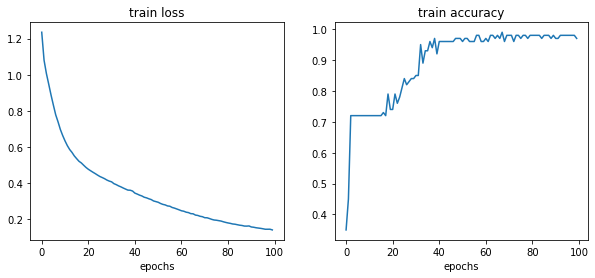

In [12]:
## 훈련정확도가 저장된 history변수를 활용, 학습곡선 그리기 
hist = history.history

fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'])
ax.set_title('train loss')
ax.set_xlabel('epochs')

ax = fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'])
ax.set_title('train accuracy')
ax.set_xlabel('epochs')

plt.show()

In [13]:
## 모형 평가 
results = iris_model.evaluate(ds_test.batch(50), verbose = 0)
results  ## loss, accuracy 

[0.14098796248435974, 0.9800000190734863]

In [17]:
## 모형 저장 및 재사용 
iris_model.save('iris-classifier.h5', 
                overwrite = True, include_optimizer = True, save_format = 'h5') 

In [18]:
## load_model
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

## use model 
iris_model_new.evaluate(ds_test.batch(33), verbose = 1)

2/2 [==============================] - 0s 1ms/step - loss: 0.1410 - accuracy: 0.9800


[0.14098796248435974, 0.9800000190734863]

---
#### 2. TensorBoard 
- EarlyStopping, Callback과 함께 사용
---

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

callback_list = [ModelCheckpoint(filepath = 'iris-earlystopping.h5', monitor = 'val_loss'),
                 EarlyStopping(patience = 3, restore_best_weights = True), TensorBoard()]

model = tf.keras.models.model_from_json(iris_model.to_json())
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(ds_train, epochs = 500, 
          steps_per_epoch = steps_per_epoch, 
          callbacks = callback_list, 
          verbose = 0) 

In [27]:
## 텐서보드 실행
%load_ext tensorboard
%tensorboard --logdir logs --port 6006

---
#### 3. 활성화 함수 
- logistic : sigmoid 함수의 일종, 이진분류 문제에서 샘플이 클래스에 속할 확률
- softmax : 다중 클래스 한경에서 의미있는 클래스 확률 계산. 샘플의 최종 입력이 i번째 클래스에 속할 확률을 지수가중된 선형함수 합으로 나누어 정규화 
- tanh : 스케일이 조정된 로지스틱 함수. 출력범위가 -1~+1로 범위가 넓다 
- relu : 복잡한 함수를 학습하기 좋은 비선형 함수. 입력값이 양수이면 기울기 1(계속 증가), 음수이면 0 
---

In [33]:
W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])

Z_tensor = tf.expand_dims(Z, axis = 0)
Z_tensor

<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[1.78, 0.76, 1.65]])>

In [62]:
a = tf.keras.activations.softmax(Z_tensor).numpy()
b = tf.keras.activations.tanh(Z_tensor).numpy()
c = tf.keras.activations.relu(Z_tensor).numpy()
print(a,'\n',b,'\n',c)

[[0.44668973 0.16107406 0.39223621]] 
 [[0.94469516 0.64107696 0.92885762]] 
 [[1.78 0.76 1.65]]
